# Graph-Based Modeling of Oak Wilt Spread (Minimum Spanning Tree)

This notebook explores a graph-theoretic approach to modeling the spread of Oak Wilt.
Instead of treating a cluster as a simple circle, we treat each infected tree as a **node** in a graph.
We assume the infection spreads from tree to tree via root grafts or insect vectors.

**Hypothesis:** The "path of least resistance" for the infection is well-approximated by a **Minimum Spanning Tree (MST)** connecting all infected trees in a cluster. The edges of the MST represent the most likely transmission links.


In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.spatial.distance import pdist, squareform
from pathlib import Path

# Load Data
members_path = Path('../data/oak_wilt_cluster_members.csv')
df_members = pd.read_csv(members_path)

print(f"Loaded {len(df_members)} trees.")
df_members.head()


Loaded 620 trees.


,cluster_id,original_label,LATITUDE,LONGITUDE,INSPECTION_YEAR,INSPECTION_DATE,SPECIES,LANDOWNER_TYPE
0,1,0,30.296323,-97.777386,1989,1989-10-11,Live Oak,Unknown
1,1,0,30.295916,-97.777216,1990,1990-06-19,Live Oak,Unknown
2,1,0,30.296262,-97.777261,1990,1990-09-19,Live Oak,Unknown
3,2,3,30.252667,-97.791031,1992,1992-01-23,"Live Oak, Red Oak",Unknown
4,2,3,30.252696,-97.791051,1994,1994-04-28,"Live Oak, Red Oak",Unknown


In [43]:
# Find the oldest data point in the entire dataset
oldest_year = df_members['INSPECTION_YEAR'].min()
oldest_trees = df_members[df_members['INSPECTION_YEAR'] == oldest_year]

print(f"Oldest Inspection Year: {oldest_year}")
print(f"Number of trees found in {oldest_year}: {len(oldest_trees)}")
print("\nDetails of oldest trees:")
print(oldest_trees[['cluster_id', 'LATITUDE', 'LONGITUDE', 'INSPECTION_DATE', 'SPECIES']])


Oldest Inspection Year: 1989
Number of trees found in 1989: 1

Details of oldest trees:
   cluster_id   LATITUDE  LONGITUDE INSPECTION_DATE   SPECIES
0           1  30.296323 -97.777386      1989-10-11  Live Oak


In [44]:
# Check cluster sizes to pick a good candidate
cluster_counts = df_members['cluster_id'].value_counts()
print("Top 5 largest clusters:")
print(cluster_counts.head())

# Select the largest cluster for initial analysis
target_cluster_id = cluster_counts.index[0]
print(f"\nAnalyzing Cluster ID: {target_cluster_id}")

cluster_data = df_members[df_members['cluster_id'] == target_cluster_id].copy()


Top 5 largest clusters:
cluster_id
74    110
54     42
59     32
73     26
72     23
Name: count, dtype: int64

Analyzing Cluster ID: 74


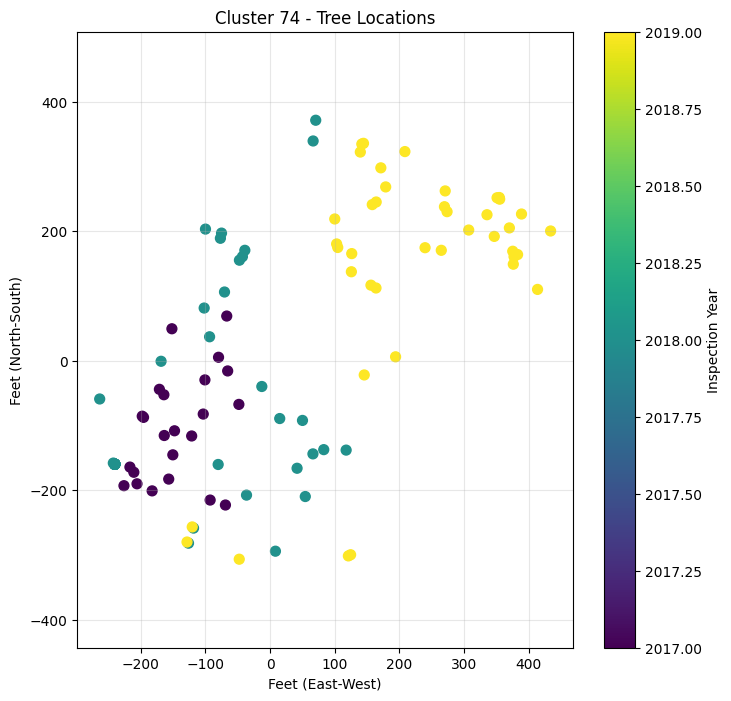

In [45]:
# Coordinate Projection (Approximate for local scale)
# 1 deg Lat ~= 364,000 ft
# 1 deg Lon ~= 288,200 ft (at 30 deg N)

LAT_TO_FT = 364000
LON_TO_FT = 288200

# Center the cluster at (0,0) for easier math
center_lat = cluster_data['LATITUDE'].mean()
center_lon = cluster_data['LONGITUDE'].mean()

cluster_data['x_ft'] = (cluster_data['LONGITUDE'] - center_lon) * LON_TO_FT
cluster_data['y_ft'] = (cluster_data['LATITUDE'] - center_lat) * LAT_TO_FT

plt.figure(figsize=(8, 8))
plt.scatter(cluster_data['x_ft'], cluster_data['y_ft'], c=cluster_data['INSPECTION_YEAR'], cmap='viridis', s=50)
plt.colorbar(label='Inspection Year')
plt.title(f"Cluster {target_cluster_id} - Tree Locations")
plt.xlabel("Feet (East-West)")
plt.ylabel("Feet (North-South)")
plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.show()


In [46]:
# Build the Complete Graph and MST

# 1. Calculate Distance Matrix
coords = cluster_data[['x_ft', 'y_ft']].values
dist_matrix = squareform(pdist(coords))

# 2. Create NetworkX Graph
G = nx.Graph()
n_points = len(cluster_data)

# Add nodes
for i in range(n_points):
    G.add_node(i, pos=(coords[i, 0], coords[i, 1]), year=cluster_data.iloc[i]['INSPECTION_YEAR'])

# Add edges (Complete Graph)
for i in range(n_points):
    for j in range(i + 1, n_points):
        dist = dist_matrix[i, j]
        G.add_edge(i, j, weight=dist)

# 3. Compute Minimum Spanning Tree
mst = nx.minimum_spanning_tree(G)

print(f"MST has {mst.number_of_edges()} edges for {n_points} nodes.")


MST has 109 edges for 110 nodes.


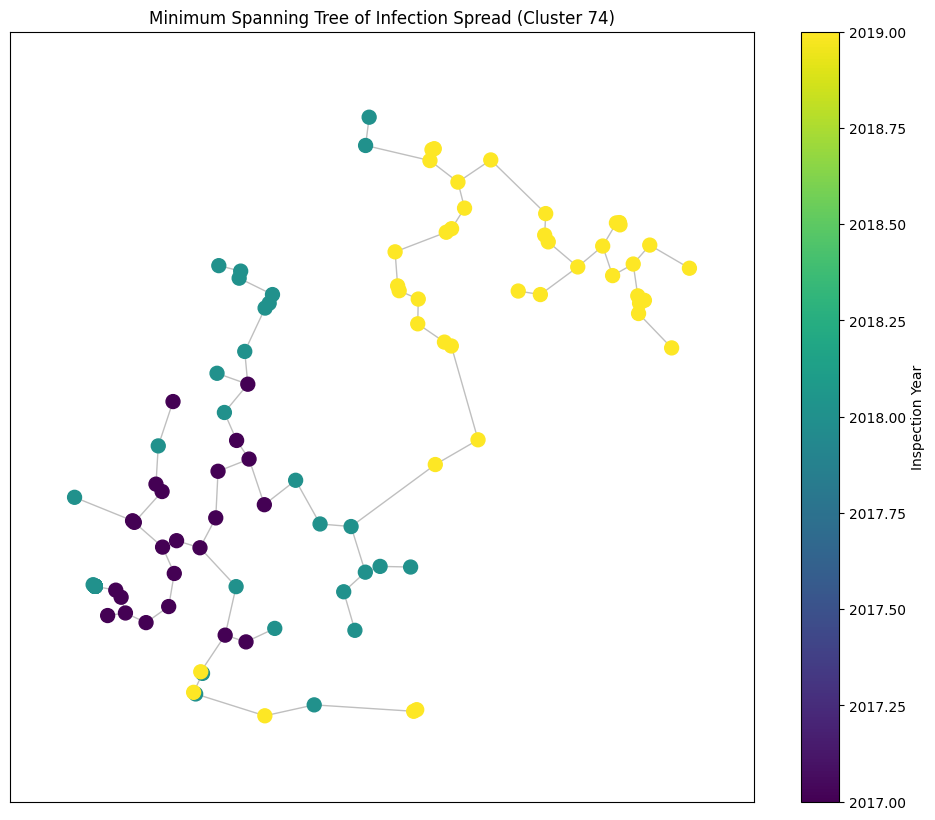

In [47]:
# Visualize the MST
pos = nx.get_node_attributes(mst, 'pos')
years = nx.get_node_attributes(mst, 'year')
node_colors = list(years.values())

plt.figure(figsize=(12, 10))

# Draw edges
nx.draw_networkx_edges(mst, pos, alpha=0.5, edge_color='gray')

# Draw nodes
nodes = nx.draw_networkx_nodes(mst, pos, node_color=node_colors, cmap='viridis', node_size=100)

# Add colorbar
plt.colorbar(nodes, label='Inspection Year')

plt.title(f"Minimum Spanning Tree of Infection Spread (Cluster {target_cluster_id})")
plt.axis('equal')
plt.show()


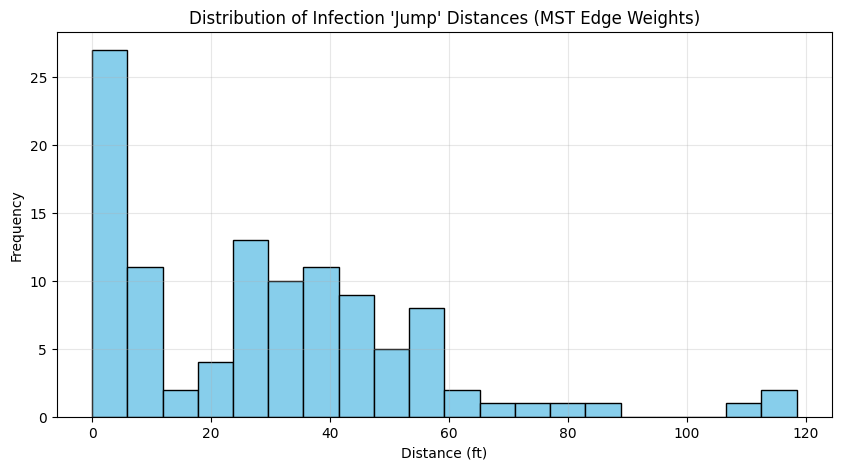

Average Jump Distance: 29.3 ft
Median Jump Distance: 27.7 ft
Max Jump Distance: 118.5 ft


In [48]:
# Analyze Spread Statistics
edge_weights = [d['weight'] for u, v, d in mst.edges(data=True)]

plt.figure(figsize=(10, 5))
plt.hist(edge_weights, bins=20, color='skyblue', edgecolor='black')
plt.title("Distribution of Infection 'Jump' Distances (MST Edge Weights)")
plt.xlabel("Distance (ft)")
plt.ylabel("Frequency")
plt.grid(True, alpha=0.3)
plt.show()

print(f"Average Jump Distance: {np.mean(edge_weights):.1f} ft")
print(f"Median Jump Distance: {np.median(edge_weights):.1f} ft")
print(f"Max Jump Distance: {np.max(edge_weights):.1f} ft")


# Temporal Directed Graph (Time-Constrained Spread)

The MST above is "undirected" and purely distance-based. It might suggest a tree infected in 1995 infected a tree found in 1990, which is impossible.

Here, we build a **Directed Graph (DiGraph)** with strict temporal logic:
1.  **Time Constraint:** A tree can only infect another tree if `Source_Year <= Target_Year`.
2.  **Distance Weight:** We still prefer shorter distances.
3.  **Root:** We assume the oldest tree(s) are the source.

This creates a "Family Tree" of the infection.


In [49]:
# Build Directed Graph with Temporal Logic

DiG = nx.DiGraph()

# Add all nodes
for i in range(n_points):
    DiG.add_node(i, pos=(coords[i, 0], coords[i, 1]), year=cluster_data.iloc[i]['INSPECTION_YEAR'])

# Add Directed Edges only if Time Logic holds
# Logic: Source Year <= Target Year
# We allow same-year transmission (<=) because inspection dates are not precise enough for <
for i in range(n_points):
    for j in range(n_points):
        if i == j:
            continue
        
        year_i = cluster_data.iloc[i]['INSPECTION_YEAR']
        year_j = cluster_data.iloc[j]['INSPECTION_YEAR']
        
        if year_i <= year_j:
            dist = dist_matrix[i, j]
            # We want the "most likely parent".
            # In a Minimum Spanning Arborescence, we minimize weight.
            # Weight = Distance.
            DiG.add_edge(i, j, weight=dist)

print(f"Directed Graph has {DiG.number_of_edges()} valid temporal edges.")


Directed Graph has 8081 valid temporal edges.


In [50]:
# Solve for Minimum Spanning Arborescence (Directed MST)
# This finds the best "parent" for every node such that total distance is minimized.

try:
    # Edmonds' algorithm for Minimum Spanning Arborescence
    min_arborescence = nx.minimum_spanning_arborescence(DiG)
    print(f"Found optimal infection tree with {min_arborescence.number_of_edges()} edges.")
except nx.NetworkXException as e:
    print(f"Could not find single tree (likely multiple independent starts): {e}")
    # Fallback: If the graph is not fully connected (e.g., multiple starts), we can just take the
    # shortest incoming edge for every node (Greedy Parent Approach)
    min_arborescence = nx.DiGraph()
    min_arborescence.add_nodes_from(DiG.nodes(data=True))
    
    for node in DiG.nodes():
        in_edges = DiG.in_edges(node, data=True)
        if in_edges:
            # Find the parent with the minimum distance
            best_edge = min(in_edges, key=lambda x: x[2]['weight'])
            min_arborescence.add_edge(best_edge[0], best_edge[1], weight=best_edge[2]['weight'])
    print(f"Fallback: Constructed Greedy Parent Tree with {min_arborescence.number_of_edges()} edges.")


Found optimal infection tree with 109 edges.


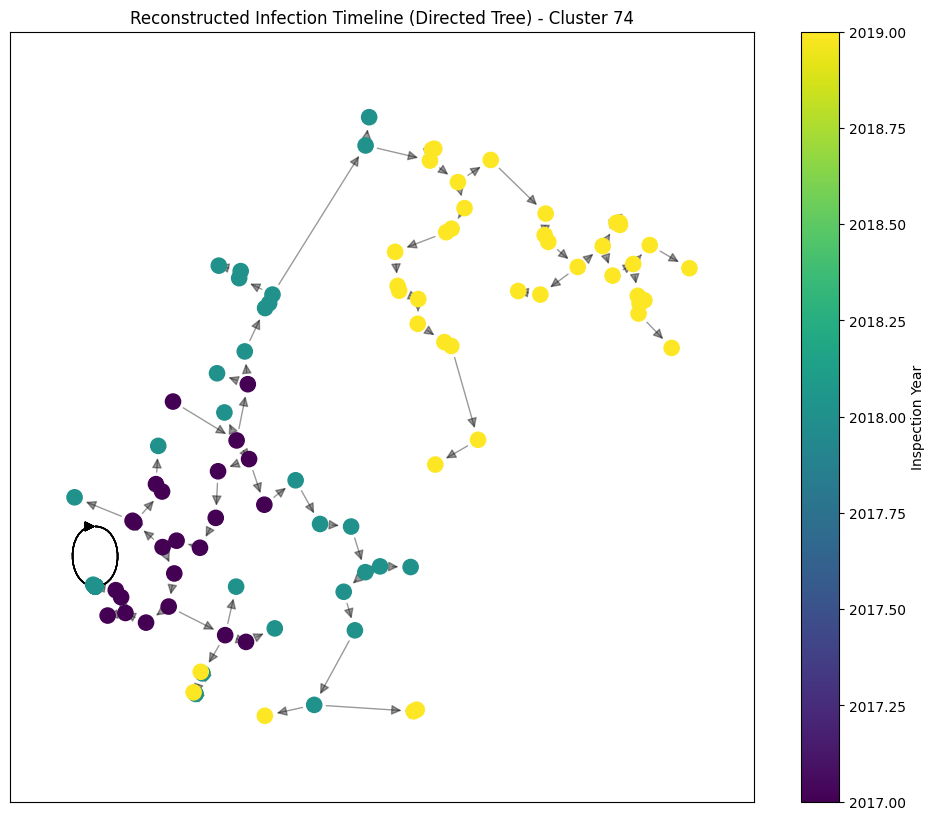

In [51]:
# Visualize the Temporal Infection Tree
# Note: We get attributes from DiG because the arborescence object might lose them during creation
pos = nx.get_node_attributes(DiG, 'pos')
years = nx.get_node_attributes(DiG, 'year')
node_colors = [years[n] for n in min_arborescence.nodes()]

plt.figure(figsize=(12, 10))

# Draw directed edges with arrows
nx.draw_networkx_edges(min_arborescence, pos, alpha=0.4, edge_color='black', arrows=True, arrowsize=15, width=1.0)

# Draw nodes
nodes = nx.draw_networkx_nodes(min_arborescence, pos, node_color=node_colors, cmap='viridis', node_size=120)

plt.colorbar(nodes, label='Inspection Year')
plt.title(f"Reconstructed Infection Timeline (Directed Tree) - Cluster {target_cluster_id}")
plt.axis('equal')
plt.show()


# Batch Processing: Generate Timelines for All Clusters

The code below iterates through every cluster in the dataset, builds its specific "Infection Timeline" (Directed MST), and saves the visualization as an image file.

This allows us to audit the spread history of every single outbreak pocket individually.


In [52]:
import os
import contextily as ctx
import geopandas as gpd
from shapely.geometry import Point

# Create output directory
output_dir = "../visualizations/timelines_geo"
os.makedirs(output_dir, exist_ok=True)

# Get list of all cluster IDs
all_cluster_ids = df_members['cluster_id'].unique()
print(f"Processing {len(all_cluster_ids)} clusters...")

# Statistics Collectors
all_risks = []
all_distances = []

for cid in all_cluster_ids:
    # 1. Filter Data
    c_data = df_members[df_members['cluster_id'] == cid].copy()
    
    # Skip tiny clusters
    if len(c_data) < 3:
        continue

    # 2. Data Cleaning & Merging Duplicates
    sites = c_data.groupby(['LATITUDE', 'LONGITUDE'])['INSPECTION_YEAR'].min().reset_index()
    
    # Sort by Year
    sites = sites.sort_values('INSPECTION_YEAR').reset_index(drop=True)
    
    # 3. Build Graph using "Nearest Older Neighbor"
    G_timeline = nx.DiGraph()
    
    # We need both Lat/Lon for mapping and Feet for distance calc
    # Simple projection for distance: 1 deg lat ~ 364000 ft, 1 deg lon ~ 288200 ft
    center_lat = sites['LATITUDE'].mean()
    center_lon = sites['LONGITUDE'].mean()
    
    sites['x_ft'] = (sites['LONGITUDE'] - center_lon) * LON_TO_FT
    sites['y_ft'] = (sites['LATITUDE'] - center_lat) * LAT_TO_FT
    
    for idx, row in sites.iterrows():
        # Store Lat/Lon in node attributes for GeoPandas
        G_timeline.add_node(idx, 
                          pos_ft=(row['x_ft'], row['y_ft']), 
                          lat=row['LATITUDE'], 
                          lon=row['LONGITUDE'],
                          year=row['INSPECTION_YEAR'])
        
    for i in range(1, len(sites)):
        current_node = sites.iloc[i]
        current_pos = np.array([current_node['x_ft'], current_node['y_ft']])
        
        potential_parents = sites.iloc[:i]
        parent_positions = potential_parents[['x_ft', 'y_ft']].values
        
        dists = np.sqrt(np.sum((parent_positions - current_pos)**2, axis=1))
        best_parent_idx = np.argmin(dists)
        min_dist = dists[best_parent_idx]
        
        risk = np.exp(-min_dist / 50.0)
        all_risks.append(risk)
        all_distances.append(min_dist)
        
        G_timeline.add_edge(best_parent_idx, i, weight=min_dist)

    # 5. Plot with Geospatial Map
    try:
        # Convert Graph Nodes to GeoDataFrame
        node_data = []
        for n, d in G_timeline.nodes(data=True):
            node_data.append({
                'id': n, 
                'year': d['year'], 
                'geometry': Point(d['lon'], d['lat'])
            })
            
        gdf_nodes = gpd.GeoDataFrame(node_data, crs="EPSG:4326")
        
        # Reproject to Web Mercator (EPSG:3857) for Contextily Basemaps
        gdf_nodes_mercator = gdf_nodes.to_crs(epsg=3857)
        
        # Extract x,y for plotting
        gdf_nodes_mercator['x'] = gdf_nodes_mercator.geometry.x
        gdf_nodes_mercator['y'] = gdf_nodes_mercator.geometry.y
        
        # Create a position dictionary for NetworkX using projected coordinates
        pos_mercator = {row['id']: (row['x'], row['y']) for idx, row in gdf_nodes_mercator.iterrows()}
        
        # Setup Plot
        fig, ax = plt.subplots(figsize=(12, 12))
        
        # Draw Basemap
        # Add buffer to bounds so nodes aren't on the edge
        minx, miny, maxx, maxy = gdf_nodes_mercator.total_bounds
        buffer = 100 # meters buffer
        ax.set_xlim(minx - buffer, maxx + buffer)
        ax.set_ylim(miny - buffer, maxy + buffer)
        
        try:
            ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
        except:
            print("Could not fetch basemap tiles (internet issue?), plotting without map.")

        # Draw Edges
        edges = G_timeline.edges(data=True)
        edge_colors = []
        
        for u, v, d in edges:
            dist = d['weight']
            if dist < 60:
                edge_colors.append('red')
            else:
                edge_colors.append('blue')

        nx.draw_networkx_edges(G_timeline, pos_mercator, ax=ax, alpha=0.6, edge_color=edge_colors, arrows=True, arrowsize=20, width=2)
        
        # Draw Nodes
        years = [d['year'] for n, d in G_timeline.nodes(data=True)]
        nodes = nx.draw_networkx_nodes(G_timeline, pos_mercator, ax=ax, node_color=years, cmap='viridis', node_size=150, edgecolors='black')
        
        # Add Colorbar
        plt.colorbar(nodes, label='Inspection Year', fraction=0.03, pad=0.04)
        
        plt.title(f"Cluster {cid} Geospatial Timeline\nBasemap: OpenStreetMap", fontsize=14)
        plt.xlabel("Easting (Web Mercator)")
        plt.ylabel("Northing (Web Mercator)")
        
        # Save
        filename = f"cluster_{cid}_geo_timeline.png"
        plt.savefig(os.path.join(output_dir, filename), dpi=100)
        plt.close()
        
    except Exception as e:
        print(f"Error plotting Cluster {cid}: {e}")

# --- Final Statistics ---
all_risks = np.array(all_risks)
low_risk_count = np.sum(all_risks < 0.50)
total_spreads = len(all_risks)
percent_low_risk = (low_risk_count / total_spreads) * 100 if total_spreads > 0 else 0

print("\n" + "="*40)
print(f"GLOBAL SPREAD STATISTICS ({total_spreads} total transmission events)")
print("="*40)
print(f"Spreads with Risk < 50%: {low_risk_count} ({percent_low_risk:.1f}%)")
print(f"Average Spread Distance: {np.mean(all_distances):.1f} ft")
print(f"Median Spread Distance:  {np.median(all_distances):.1f} ft")
print("="*40)


Processing 79 clusters...

GLOBAL SPREAD STATISTICS (409 total transmission events)
Spreads with Risk < 50%: 289 (70.7%)
Average Spread Distance: 83.9 ft
Median Spread Distance:  66.1 ft
